## import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import ResidualsPlot

## df

In [2]:
df_registros_prod = pd.read_excel("../../dist/registros-prod.xlsx")
df_analise_preditiva = pd.read_excel("../../dist/analise-preditiva.xlsx")
df_analise_prescritiva = pd.read_excel("../../dist/analise-prescritiva.xlsx")

## functions & var

In [3]:
def fnc_Dummies(df):
    for cat_feature in df.select_dtypes(include=['object']).columns:
        df[cat_feature] = pd.Categorical(df[cat_feature]).codes
        df[cat_feature] = df[cat_feature].replace(-1,np.nan)
    return pd.DataFrame(df)

## 1. Análise Descritiva

In [4]:
# Tipo de dados original
df_registros_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
QTD_CHOC       500 non-null float64
VAR_1          500 non-null float64
VAR_2          500 non-null object
PESO_BOMBOM    500 non-null float64
dtypes: float64(3), object(1)
memory usage: 15.7+ KB


In [5]:
# Conversão de variáveis categóricas
df_registros_prod_v2 = fnc_Dummies(df_registros_prod.copy())
df_registros_prod_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
QTD_CHOC       500 non-null float64
VAR_1          500 non-null float64
VAR_2          500 non-null int8
PESO_BOMBOM    500 non-null float64
dtypes: float64(3), int8(1)
memory usage: 12.3 KB


In [6]:
# Descritiva básica de features
df_registros_prod_v2.describe()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM
count,500.000000,500.000000,500.000000,500.000000
mean,291.264600,2.098180,1.038000,10.395002
std,45.182499,0.711166,0.818472,1.572233
min,112.910000,0.050000,0.000000,4.543124
25%,259.267500,1.630000,0.000000,9.425819
50%,295.450000,2.300000,1.000000,10.334273
75%,325.137500,2.672500,2.000000,11.379932
max,436.070000,2.980000,2.000000,17.362728


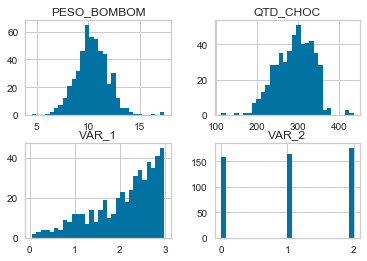

In [7]:
# Histogramas
df_registros_prod_v2.hist(bins=30);

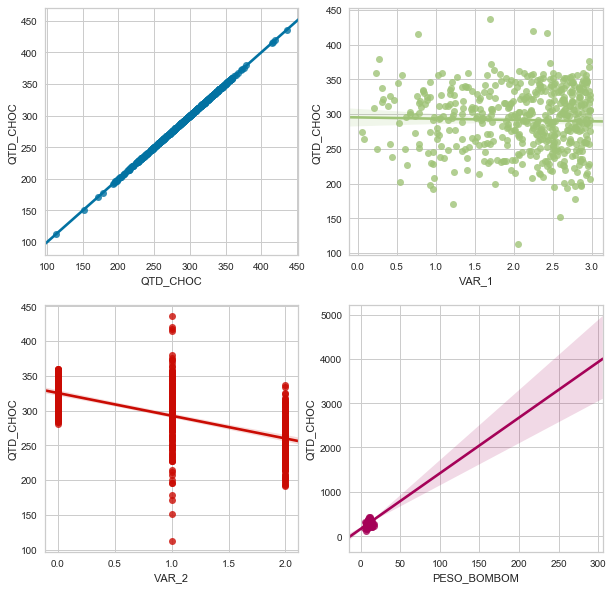

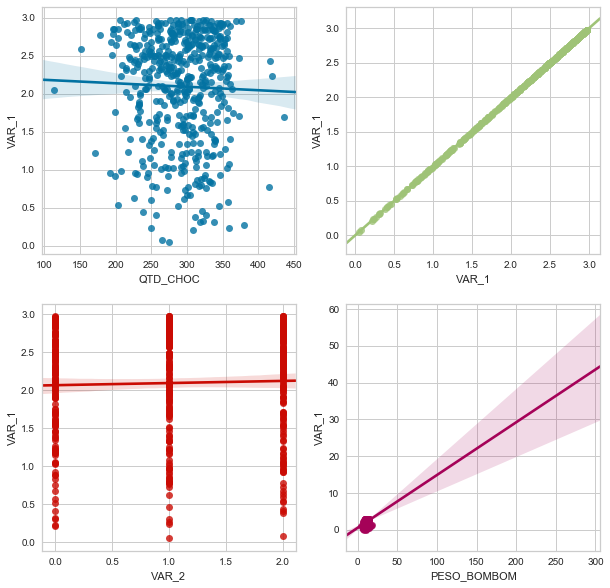

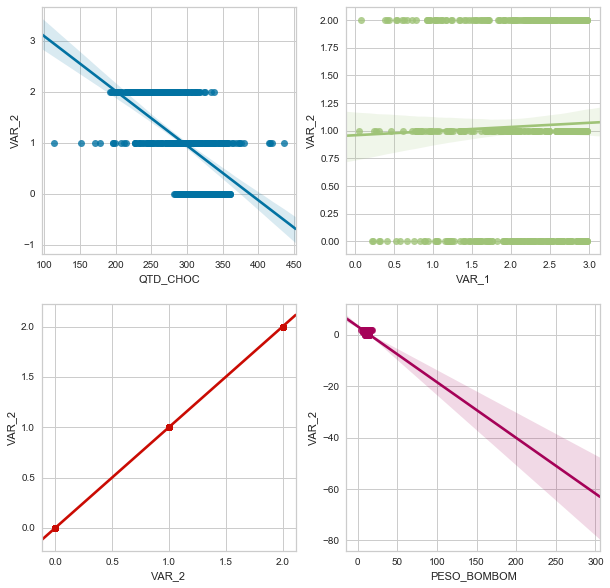

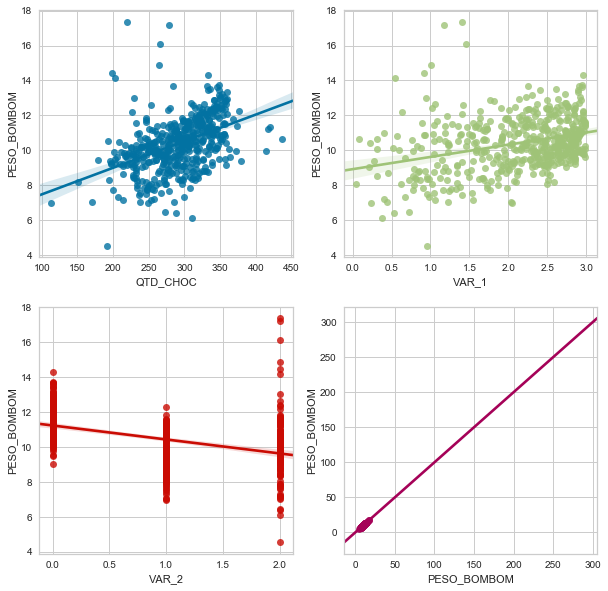

In [8]:
# Regressão Linear Simples (todos vs todos)
lista = df_registros_prod_v2.columns
for var_interesse in lista:
    features_to_analyse = lista
    fig, ax = plt.subplots(2, 2, figsize = (10,10))
    for i, ax in enumerate(fig.axes):
        if i < len(features_to_analyse):
            sns.regplot(x=features_to_analyse[i],y=var_interesse, data=df_registros_prod_v2[features_to_analyse], ax=ax)

## 2. Análise Diagnóstica

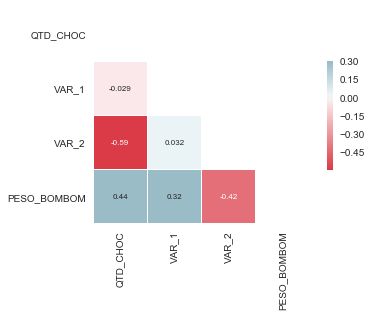

In [9]:
# Mztriz de Correlação de Pearson
corr = df_registros_prod_v2.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, annot_kws={"size": 8}, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

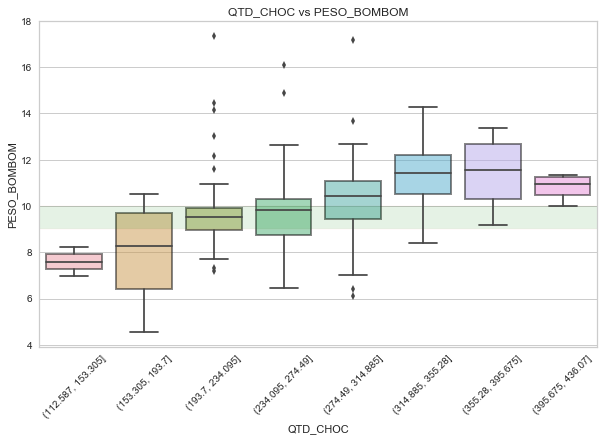

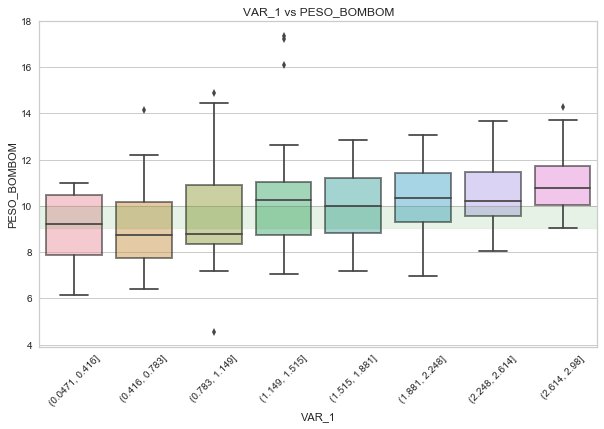

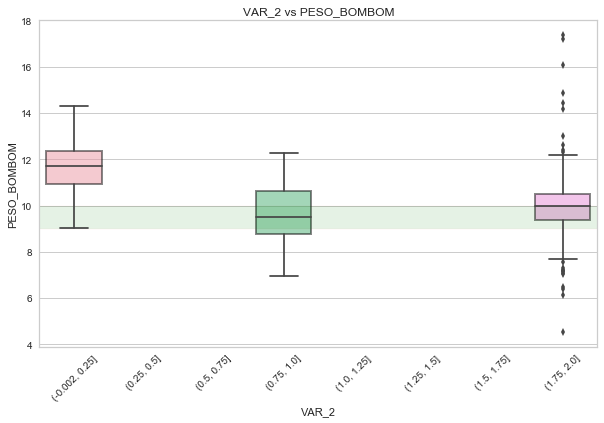

In [10]:
# Boxplot com bucket/8 + faixa ideal para peso
for var_boxplot in ['QTD_CHOC', 'VAR_1', 'VAR_2']:    
    plt.figure(figsize = (10, 6))
    ax = sns.boxplot(x=pd.cut(df_registros_prod_v2[var_boxplot], 8), y='PESO_BOMBOM', data=df_registros_prod_v2)
    
    # Faixa de peso ideal 9-10g
    rect = plt.Rectangle((-1,9),100,1,color='green', alpha=0.1, ec='red')
    ax.add_patch(rect)
    ax.set_title(str(var_boxplot+' vs PESO_BOMBOM'))
    
    plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
    plt.xticks(rotation=45)

## 3. Análise Preditiva

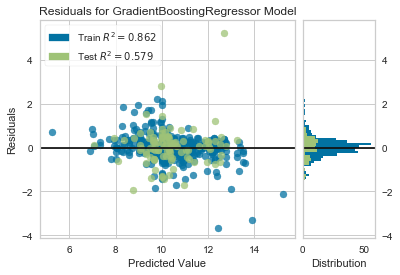

In [11]:
# Distribuição de erros - GradientBoostingRegressor
df_mqo_v3 = df_registros_prod_v2

# Variáveis para treino
feature_names = ['QTD_CHOC', 'VAR_1', 'VAR_2']
target_name = ['PESO_BOMBOM']

X = df_mqo_v3[feature_names]
y = df_mqo_v3[target_name].values.ravel()

# Separa dados para treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Prepara modelo para gráfico
model = GradientBoostingRegressor()
visualizer = ResidualsPlot(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [12]:
# Mean squared error
train_model = model.fit(X,y)
y_true = y
y_pred = train_model.predict(X)
print('MSE: ', mean_squared_error(y_true, y_pred))

MSE:  0.345853058917026


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016AF4290B38>,
      dtype=object)

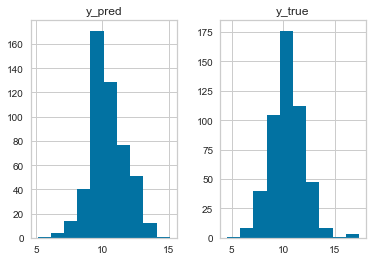

In [13]:
# Comparativo
df_metric = pd.DataFrame(columns=['y_true','y_pred'])
df_metric['y_true'] = y_true
df_metric['y_pred'] = y_pred
df_metric.hist()

In [14]:
# Faz cópia de dataset
df_analise_preditiva_v2 = fnc_Dummies(df_analise_preditiva)

# Variáveis para predict
feature_names = ['QTD_CHOC', 'VAR_1', 'VAR_2']
X_2 = df_analise_preditiva_v2[feature_names]

# Carrega modelo para predict
df_analise_preditiva_v2['PESO_BOMBOM'] = model.predict(X_2)

In [15]:
df_analise_preditiva_v2.describe()

,QTD_CHOC,VAR_1,VAR_2,PESO_BOMBOM
count,50.000000,50.000000,50.000000,50.000000
mean,294.613400,2.191200,1.040000,10.269148
std,42.792363,0.632225,0.754848,1.140194
min,208.000000,0.630000,0.000000,8.033647
25%,265.457500,1.902500,0.250000,9.572751
50%,295.120000,2.320000,1.000000,9.997257
75%,320.142500,2.727500,2.000000,10.959749
max,387.760000,2.980000,2.000000,13.028284


In [16]:
# Salva predições
writer = pd.ExcelWriter('analise-preditiva-new.xlsx', engine='xlsxwriter')
df_analise_preditiva_v2.to_excel(writer, sheet_name='Sheet1', index=False)
writer.save()

## Bônus - lime

## 4. Análise Prescritiva